In [1]:
!pip3 install torch torchvision torchaudio # Default to CUDA 10.2 https://pytorch.org/get-started/locally/
!pip install ipywidgets
!pip install sklearn
!pip install matplotlib

## Read Data functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import json
from PIL import Image
import os

label_names = ['finger_point', 'fist', 'index_pick', 'middle_pick', 'palm', 'thumb_up', 'victory']
matching_label = ["n/a", "drag", "point", "swipe", "click", "right-click"]
mapping_dict = {
    0: 0,
    1: 1, #TODO
    2: 4,
    3: 5,
    4: 2,
    5: 0,
    6: 0
}

def readData(directory):
    data = []
    img_data = []
    y = []
    y_i = []
    cropped_img_data = []
    # Data being read here
    # Default directory name ./data_collector/(gesture type)/(image/label)
    for i, folder in enumerate(label_names):
        baseD = os.path.join(directory, folder)
        labelsD = os.path.join(baseD, 'labels')
        imageD = os.path.join(baseD, 'images')

        for filename in os.listdir(labelsD):
            labelFileName = os.path.join(labelsD, filename)
            imageFileName = os.path.join(imageD, filename.split('.')[0] + ".png")

            with open(labelFileName, 'r') as f:
                data.append(json.load(f))
                y.append(folder)
                y_i.append(i)
                f.close()

            img_data.append(Image.open(imageFileName))
            
            im = img_data[-1].copy()
            landmark = data[-1]['multi_hand_landmarks']
            xs = [int(l['x'] * im.size[0]) for l in landmark]
            ys = [int(l['y'] * im.size[1]) for l in landmark]
            boundary_x_left = max(0, min(xs) - 50)
            boundary_x_right = min(im.size[0], max(xs) + 50)
            boundary_y_up = max(0, min(ys) - 50)
            boundary_y_down = min(im.size[1], max(ys) + 50)
            
            im = im.crop((boundary_x_left, boundary_y_up, boundary_x_right, boundary_y_down))
            cropped_img_data.append(im)

    return np.array(data), np.array(img_data), np.array(y), np.array(y_i), np.array(cropped_img_data)


def balance_data(data, img_data, y_i, cropped_img):
    # Balance data classes. 
    y_counts = np.bincount(y_i)
    num_per_y = y_counts.min()
    final_sel = np.ones(len(y_i), dtype = 'bool')
    for i in range(len(label_names)):
        sel = np.array(y_i) == i
        sel[np.where(sel)[0][:num_per_y]] = False
        final_sel[sel] = False

    data_X = data[final_sel]
    data_y = y_i[final_sel]
    img_data_X = img_data[final_sel]
    cropped = cropped_img[final_sel]
    
    return data_X, img_data_X, data_y, cropped

## Read Data


In [2]:
DIR1 = './data_collector'
DIR2 = './test_data'
DIR3 = './skye'

data1, img_data1, y1, y1_i, cropped_img_data1 = readData(DIR1)
data1_balanced, img_data1_balanced, y1_i_balanced, cropped_img_data1_balanced = \
    balance_data(data1, img_data1, y1_i, cropped_img_data1)

data2, img_data2, y2, y2_i, cropped_img_data2 = readData(DIR2)
data2_balanced, img_data2_balanced, y2_i_balanced, cropped_img_data2_balanced = \
    balance_data(data2, img_data2, y2_i, cropped_img_data2)

data3, img_data3, y3, y3_i, cropped_img_data3 = readData(DIR3)
data3_balanced, img_data3_balanced, y3_i_balanced, cropped_img_data3_balanced = \
    balance_data(data3, img_data3, y3_i, cropped_img_data3)

/tmp/ipykernel_1250077/1833855824.py:47: FutureWarning: The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(data), np.array(img_data), np.array(y), np.array(y_i), np.array(cropped_img_data)
/tmp/ipykernel_1250077/1833855824.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), np.array(img_data), np.array(y), np.array(y_i), np.array(crop

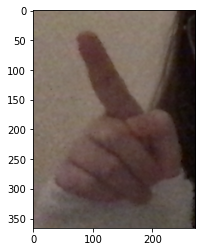

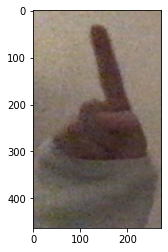

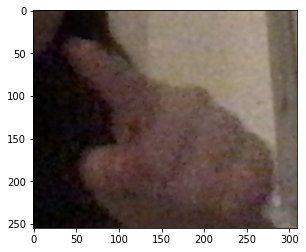

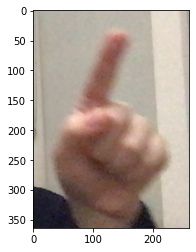

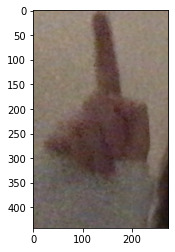

In [43]:
for i in range (0, 5):
    plt.imshow(cropped_img_data1[i])
    plt.show()

In [4]:
total_data = np.concatenate((data1, data2), axis = 0)
total_img_data = np.concatenate((img_data1, img_data2), axis = 0)
total_y = np.concatenate((y1, y2), axis = 0)
total_y_i = np.concatenate((y1_i, y2_i), axis = 0)
total_cropped = np.concatenate((cropped_img_data1, cropped_img_data2), axis = 0)

total_data_balanced, total_img_data_balanced, total_y_i_balanced, total_cropped_balanced = \
    balance_data(total_data, total_img_data, total_y_i, total_cropped)

print(len(total_data))

3896


## Use MLP

In [11]:
def extract_mlp_data(data, y):
    aa = []
    X = []
    for a in data : aa.append(a['multi_hand_landmarks'])
    for d in aa:
        singleData = []
        for landmark in d:
            singleData.append(landmark['x'])
            singleData.append(landmark['y'])
            singleData.append(landmark['z'])
        X.append(singleData)

    X = np.array(X)
    y = np.array(y)
    
    return X, y

# X, y = extract_mlp_data(data1_balanced, y1_i_balanced)
X, y = extract_mlp_data(total_data_balanced, total_y_i_balanced)

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, )

clf = MLPClassifier(hidden_layer_sizes=(100), max_iter=100000, learning_rate='adaptive').fit(X_train, y_train)

In [13]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9902302861130495
0.9916434540389972


In [16]:
t_X, t_y = extract_mlp_data(data3, y3_i)
print(clf.score(t_X, t_y))

0.7853470437017995


In [20]:
import pickle
with open("mlp_classifier.pickle", "wb") as f:
    pickle.dump(clf, f)

In [23]:
clf.predict([[0] * 3 * 21])

array([1])

## Use MobileNet v2

In [9]:
from torchvision import transforms
import torch

def preprocess_mobilenet_data(imdata):
    # Resize data. 
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    processed = [preprocess(im) for im in imdata]
    processed = torch.stack(processed)
    
    return processed

preprocessed_img_data = preprocess_mobilenet_data(total_cropped_balanced)
data_X = preprocessed_img_data
data_y = total_y_i_balanced
print(data_X.shape)
print(data_y.shape)

torch.Size([1792, 3, 256, 256])
(1792,)


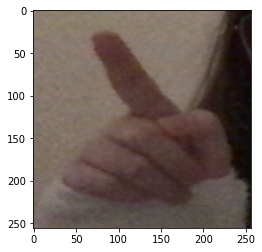

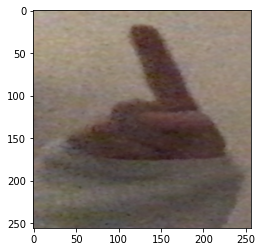

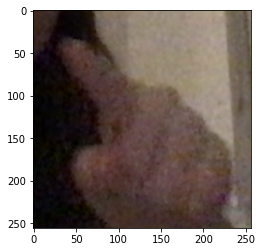

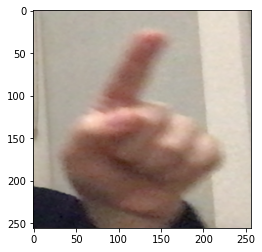

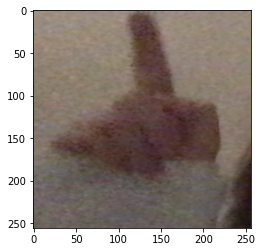

In [45]:
for im in preprocessed_img_data[:5]:
    plt.imshow(np.transpose(im, (1, 2, 0)))
    plt.show()

In [10]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, stratify=data_y, test_size=0.3)

def get_dataloader(X, y):
    dataloader = DataLoader(
        [(X[i], y[i]) for i in range(len(X))], 
        batch_size=16, 
        shuffle=True
    )
    return dataloader

train_dataloader = get_dataloader(X_train, y_train)
print(np.bincount(y_train))

test_dataloader = get_dataloader(X_test, y_test)
print(np.bincount(y_test))

[180 179 179 179 179 179 179]
[76 77 77 77 77 77 77]


In [28]:
import torch.nn as nn
import torchvision.models as models
# resnet18 = models.resnet18(pretrained=True)

def get_model(freeze_extraction_layers = False):
    model = models.mobilenet_v2(pretrained=True)

    model.classifier[1] = nn.Linear(model.last_channel, len(label_names))

    if (freeze_extraction_layers):
        for param in model.parameters():
            param.requires_grad = False
        for layer in model.classifier:
            for param in layer.parameters():
                param.requires_grad = True
                
    if torch.cuda.is_available():
        model.to('cuda')
    return model

model = get_model(freeze_extraction_layers = False)

In [12]:
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [35]:
import torch.optim as optim

def train(model, dataloader, lr = 1e-4, num_epoch = 30):
    torch.cuda.empty_cache()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    PRINT_BATCH_NUM = len(dataloader)

    best_acc = 0
    best_loss = 1e100000

    for epoch in range(num_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        epoch_loss = 0.0
        correct = 0

        for i, data in enumerate(dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if torch.cuda.is_available():
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (torch.max(outputs.data, 1)[1] == labels).float().sum().item()

            # print statistics
            running_loss += loss.item()
            epoch_loss += loss.item()
            if i % PRINT_BATCH_NUM == (PRINT_BATCH_NUM - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / PRINT_BATCH_NUM:.3f}')
                running_loss = 0.0

        epoch_acc = correct / len(dataloader.dataset)
        epoch_loss = epoch_loss / len(dataloader.dataset)
        print(f'accuracy: {epoch_acc}')

        if (epoch_loss < best_loss):
            best_loss = epoch_loss
            torch.save(model.state_dict(), f'model_parameters_loss_{best_loss:.6f}.pt')

    return best_acc, best_loss
best_acc, best_loss = train(model, train_dataloader, lr = 1e-4, num_epoch = 5)

[1,    79] loss: 0.034
accuracy: 0.9856459330143541
[2,    79] loss: 0.040
accuracy: 0.9864433811802232
[3,    79] loss: 0.050
accuracy: 0.9872408293460925
[4,    79] loss: 0.032
accuracy: 0.9896331738437002
[5,    79] loss: 0.028
accuracy: 0.9896331738437002


In [36]:
def load_model_state(model, best_loss):
    best_model_name = f'model_parameters_loss_{best_loss:.6f}.pt'
    print(f'loading {best_model_name}')

    model.load_state_dict(torch.load(best_model_name))

def eval_model(model, dataloader, print_graph = False):

    criterion = nn.CrossEntropyLoss()
    
    y_pred = None
    with torch.no_grad():
        correct = 0

        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            if torch.cuda.is_available():
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

            outputs = model(inputs)
            pred = torch.max(outputs.data, 1)[1]
            loss = criterion(outputs, labels)

            correct += (pred == labels).float().sum().item()
            running_loss += loss.item()

            if (y_pred is None):
                y_pred = pred.unsqueeze(-1).cpu().detach()
            else:
                y_pred = torch.vstack((y_pred, pred.unsqueeze(-1).cpu().detach()))

            if print_graph:
                for j in range(len(inputs)):
                    plt.imshow(inputs[j].cpu().permute(1, 2, 0))
                    plt.show()
                    print(f"Label: {labels[j]}, {label_names[labels[j]]}")
                    print(f"Pred: {pred[j]}, {label_names[pred[j]]}")

        acc = correct / len(dataloader.dataset)

    print(running_loss)
    print(acc)
# for i in np.unique(y_test):
#     print(i)
#     print((y_pred[y_test == i, 0] == i).sum() / np.bincount(y_test)[i])
load_model_state(model, best_loss)
eval_model(model, test_dataloader)

loading model_parameters_loss_0.001748.pt
3.55003646860132
0.966542750929368


In [37]:
t_y_i = np.array(y3_i)
t_preprocessed_img_data = preprocess_mobilenet_data(cropped_img_data3)
t_dataloader = get_dataloader(t_preprocessed_img_data, t_y_i)

In [38]:
eval_model(model, t_dataloader)

113.52996039390564
0.6349614395886889
